In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import set_config
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, \
                                    cross_val_predict, ParameterGrid
from sklearn.metrics import accuracy_score, make_scorer, precision_score,\
                            recall_score, f1_score, confusion_matrix, roc_curve, fbeta_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, \
                                  MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from lightgbm import LGBMClassifier
from matplotlib.gridspec import GridSpec

from collections import Counter
import joblib
import shap

import os
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    from xgboost import XGBClassifier

In [3]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

# Sets sklearn config to look at pipelines

set_config(display="diagram")

# Inits JavaScript for SHAP vizualisations

shap.initjs()

In [4]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [5]:
# Functions 

def return_scores_df(cv_results):
    
    """Return a dataframe with the provided scores"""
    
    scores_df = pd.DataFrame(columns = ['roc_auc','fit_time'])

    scores_df['roc_auc'] = \
        cv_results['mean_test_roc_auc']

    scores_df['fit_time'] = \
        cv_results['mean_fit_time']
    
    
    return scores_df

def business_simulation(targets, amounts,predicted_proba_class_1, 
                        increase=1.03, loss=0.5, 
                        range_threshold =[0.1,1], range_size=10):
    
    
    # Creates a df that regroups predicted proba of class 1, actual target and 
    # the amount of the attributed loan
    
    concat_df = \
        pd.concat([targets,
                   amounts, 
                   pd.DataFrame(predicted_proba_class_1, 
                                columns=['ProbaClass1'], 
                                index=targets.index)],
                  axis = 1)
    
    # Adds a feature with the actual rates scenario
    
    concat_df['TARGET_RATE'] =\
        concat_df['TARGET'].apply(lambda x: increase if x == 0 else loss).values
    
    # Creates one feature for each threshold
    
    for thresholds in np.linspace(range_threshold[0], range_threshold[1], range_size):

        concat_df['THR_' + str(thresholds)] = \
            (concat_df['ProbaClass1'] >= thresholds).astype(int)
        
    # Retrieves the name of the created threshold features
    
    thresholds_list = [column for column in concat_df.columns 
                      if column.startswith('THR')]
        
    # Reverse the 0 and 1 of thresholds for multpiplication with TARGET_RATE
    # (the real increase loss that happened). Put 1 in 0 will allow to do rate*0
    # therefore not take into account the amount 
    # (as it was not given -- class 1 : not attributed)
    # The particule _R (Reversed) is added at the end of the nex feature name 
    
    for column in thresholds_list:
        concat_df[column + '_R'] = concat_df[column].apply(lambda x : 0 if x == 1 else 1)
        
        
    # Computes the profit of each thresholds and stores the results in a df 
    
    # Inits the returned df
    
    profits_df = pd.DataFrame(columns=['Threshold', 'Profit'])
    
    # Inits two list for storage conveniency
    
    profit_list = []
    
    for threshold in thresholds_list:
        
        # Add the _R (Reversed particule) to the threshold name
        threshold = threshold + '_R'

        # Given a threshold the total money landed is equal to the sum of each amounts accorded
        # eg THR_X_R = 1.  
    
        money_lended = (concat_df[threshold]*concat_df['AMT_CREDIT']).sum()
    
    
        # Given a threshold the return on investment is equal to the 
        # THR_X_R (1: attributed, 0: not attrbuted)
        # * the actual rate(increase if the client have been solvable loss if not)
        # * the lended money for each client
    
        roi = (concat_df[threshold]*concat_df['TARGET_RATE']*concat_df['AMT_CREDIT']).sum()

        # The profit is equal to the return on investment minus the initial money lended
        profit = roi - money_lended
        
        profit_list.append(profit)
    
    # Commits the results
    profits_df['Profit'] = profit_list
    
    profits_df['Threshold'] = np.linspace(range_threshold[0], range_threshold[1], range_size)
    
    # Find the optimal threshold
    
    optimal_business_threshold = \
        profits_df.sort_values(by='Profit', ascending=False).iloc[0]['Threshold']
    
    return profits_df, optimal_business_threshold

def plot_simulation_profits(profits_dataframe):
    
    fig, ax = plt.subplots(figsize=(20,10)) 

    sns.lineplot(data=profits_dataframe, 
                 x='Threshold', 
                 y='Profit',
                 ax=ax,
                 color=sns.color_palette('mako')[1],
                 linewidth = 4
                )
    ax.axhline(y=0, color='black')
    ax.tick_params(labelsize=tick_size)
    ax.set_title('Profit Business Simulation', fontsize=title_size, pad=30)
    ax.set_ylabel('Profit', fontsize=text_size + 10)
    ax.set_xlabel('Threshold', fontsize=text_size + 10)
    ax.yaxis.offsetText.set_fontsize(text_size)
    plt.show();
    
def plot_roc_curves(y_train, y_train_pred_proba, optimal_business_threshold):
    # Computes false positive rates, true positive rates and thresholds of the ROC Curve

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba)

    # Computes the mathematical optimal threshold 

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Computes the business optimal threshold 

    difference_array = np.absolute(thresholds - optimal_business_threshold)
    closest_threshold_index = difference_array.argmin()

    optimal_business_fpr = fpr[closest_threshold_index]
    optimal_business_tpr = tpr[closest_threshold_index]

    # Plots the ROC Curve

    fig, (ax1, ax2) = plt.subplots(figsize=(30,20), ncols = 2)

    # AX1

    sns.lineplot(x=fpr, 
                 y=tpr,
                 ax=ax1,
                 color='black'
                )

    ax1.set_aspect('equal')
    ax1.tick_params(labelsize=tick_size - 10)
    ax1.set_title('ROC Curve', fontsize=title_size, pad=30)
    ax1.set_ylabel('True Positive Rate', fontsize=text_size + 10)
    ax1.set_xlabel('False Positive Rate', fontsize=text_size + 10)


    ax1.plot([0, 1], [0, 1], '--', color='white')
    ax1.fill_between(fpr, tpr, color=sns.color_palette('mako')[5])

    # Optimal threshold 

    ax1.scatter(optimal_fpr, optimal_tpr, color='black')
    ax1.hlines(y=optimal_tpr, xmin=0, xmax=optimal_fpr, color='black', linestyle='--')
    ax1.vlines(x=optimal_fpr, ymin=0, ymax=optimal_tpr, color='black', linestyle='--')
    ax1.annotate('optimum thr=' + str(optimal_threshold), 
             xy=[optimal_fpr - 0.20, optimal_tpr + 0.02], fontsize=text_size)


    # AX2

    sns.lineplot(x=fpr, 
                 y=tpr,
                 ax=ax2,
                 color='black'
                )

    ax2.set_aspect('equal')
    ax2.tick_params(labelsize=tick_size - 10)
    ax2.set_title('ROC Curve (Business Simulation)', fontsize=title_size, pad=30)
    ax2.set_ylabel('True Positive Rate', fontsize=text_size + 10)
    ax2.set_xlabel('False Positive Rate', fontsize=text_size + 10)


    ax2.plot([0, 1], [0, 1], '--', color='white')
    ax2.fill_between(fpr, tpr, color=sns.color_palette('mako')[5])

    # Optimal threshold 

    ax2.scatter(optimal_business_fpr, optimal_business_tpr, color='black')
    ax2.hlines(y=optimal_business_tpr, xmin=0, xmax=optimal_business_fpr, 
               color='black', linestyle='--')
    ax2.vlines(x=optimal_business_fpr, ymin=0, ymax=optimal_business_tpr, 
               color='black', linestyle='--')
    ax2.annotate('Business opt. thr=' + str(optimal_business_threshold), 
                 xy=[optimal_business_fpr - 0.20, optimal_business_tpr + 0.02], 
                 fontsize=text_size)

    plt.show();
    
    return optimal_threshold

def plot_confusion_matrix_evolution(y, pred_proba):
    
    fig = plt.figure(figsize=(12,50))

    gs = GridSpec(5, 2)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])
    ax5 = fig.add_subplot(gs[4])
    ax6 = fig.add_subplot(gs[5])
    ax7 = fig.add_subplot(gs[6])
    ax8 = fig.add_subplot(gs[7])
    ax9 = fig.add_subplot(gs[8])
    ax10 = fig.add_subplot(gs[9])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]


    for i, j in enumerate(np.linspace(0.1, 1, 10)):
    
        confusion_matrix_iter = \
            confusion_matrix(y, (pred_proba >= j).astype(int))

    
        sns.heatmap(pd.DataFrame(confusion_matrix_iter), 
                    annot=True, 
                    fmt=".0f", 
                    square=True,
                    ax = axes[i],
                    cbar=False,
                    annot_kws={"size": text_size},
                    cmap=sns.color_palette('mako', as_cmap=True),
        )
    
    
        axes[i].set_ylabel('Actual Class', fontsize=text_size)
        axes[i].set_xlabel('Predicted Class', fontsize=text_size)
        axes[i].tick_params(labelsize=tick_size)
        axes[i].set_title('Thr={:.2f}'.format(j), fontsize=title_size-10)
    
    fig.tight_layout()
    fig.suptitle('Confusion Matrix Evolution', fontsize=title_size)

    plt.show();
    
def plot_optimal_confusion_matrix(y, predicted_proba, threshold):

    fig, ax = plt.subplots(figsize=(7,7))

    optimal_confusion_matrix = \
            confusion_matrix(y, (predicted_proba >= threshold).astype(int))


    sns.heatmap(pd.DataFrame(optimal_confusion_matrix), 
                annot=True, 
                fmt=".0f", 
                square=True,
                ax = ax,
                cbar=False,
                annot_kws={"size": text_size},
                cmap=sns.color_palette('mako', as_cmap=True),
    )

    ax.set_ylabel('Actual Class', fontsize=text_size)
    ax.set_xlabel('Predicted Class', fontsize=text_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_title('Thr={:.2f}'.format(threshold), fontsize=title_size-10)
    plt.show();

<h1>Set up

In [6]:
# Imports application_train.csv

application_train = pd.read_csv(r'D:\Projet7\application_train_cleaned')

random_seed = 34

In [7]:
speed = application_train.shape[0]/10
round(speed)

application_train = application_train.iloc[:round(speed)].copy()

30751

In [8]:
# Applies a stratified sampling on application train

stratified_shuffle_split = StratifiedShuffleSplit(test_size=0.2, random_state=random_seed)

for train_index, test_index in stratified_shuffle_split\
                                    .split(application_train.drop('TARGET', axis = 1), 
                                           application_train['TARGET']):
    strat_train_set = application_train.loc[train_index]
    strat_test_set = application_train.loc[test_index]

print('Original counter :')
application_train_counter = Counter(application_train['TARGET'])
application_train_counter

(application_train_counter[1]/sum(application_train_counter.values()))*100

print('Stratified Train counter :')
strat_train_set_counter = Counter(strat_train_set['TARGET'])
strat_train_set_counter

(strat_train_set_counter[1]/sum(strat_train_set_counter.values()))*100

print('Stratified Test counter :')
strat_test_set_counter = Counter(strat_test_set['TARGET'])
strat_test_set_counter

(strat_test_set_counter[1]/sum(strat_test_set_counter.values()))*100

Original counter :


Counter({1: 2464, 0: 28287})

8.012747552925108

Stratified Train counter :


Counter({0: 22629, 1: 1971})

8.012195121951219

Stratified Test counter :


Counter({0: 5658, 1: 493})

8.014956917574379

In [9]:
# Removes TARGET and SK_ID_CURR from Xs
# Creates y_train and y_test keeping the tagrets

X_train = strat_train_set.drop(['SK_ID_CURR','TARGET'], axis=1)
y_train = strat_train_set['TARGET'].copy()

X_test = strat_test_set.drop(['SK_ID_CURR','TARGET'], axis=1)
y_test = strat_test_set['TARGET'].copy()

<h1>Utilities

<h6>Scorings

In [10]:
# Defines a scoring dictionary

scoring = {'roc_auc': 'roc_auc'}

<h6>Weights

In [11]:
# Creates a weights list for further usage with class_weights 

#weights = np.linspace(0.05, 0.95, 5)

weights = np.linspace(0.275, 0.5, 2)

weights

array([0.275, 0.5  ])

<h6>Sampling

In [12]:
# Creates a sampling list for further usage with Sapmling Pipeline

sampling_list = [
    None,
    #SMOTE(random_state=34),
    #ADASYN(random_state=34),
    #RandomUnderSampler(random_state=34),
    #ClusterCentroids(estimator = MiniBatchKMeans(n_clusters=round(Counter(y_train)[1]),
    #                                             random_state=random_seed,
    #                                             batch_size = 2048),
    #                 random_state=random_seed)
]

<h6>Scaler

In [13]:
scaler_list = [
    #StandardScaler(), 
    MinMaxScaler()
]

<h6>Feature Selection

In [14]:
# Creates a feature_selectors list for further usage with Sapmling Pipeline

feature_selectors_list = \
[
 #None,
 #SelectFromModel(DecisionTreeClassifier(random_state=random_seed), threshold=2e-3), 
 #SelectFromModel(DecisionTreeClassifier(random_state=random_seed), threshold=1e-3), 
 #SelectFromModel(RandomForestClassifier(random_state=random_seed), threshold=2e-3), 
 #SelectFromModel(RandomForestClassifier(random_state=random_seed), threshold=1e-3), 
 SelectFromModel(LGBMClassifier(random_state=random_seed), threshold='median'), 
 #SelectFromModel(LGBMClassifier(random_state=random_seed), threshold=1)
]

<h6>Column Transformer

In [15]:
# Individual pipelines for further types processing 
# Both are used in the ColumnTransformer in the cell below

# One Hot Encode Pipeline

categorical_pipeline = Pipeline([
    ('One_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False))
])

# Median imputer Pipeline 

numerical_pipeline = Pipeline([
    ('Simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
])

In [16]:
# Column Transformer

column_transformer = \
    ColumnTransformer([
        ('Categorical_pipeline', categorical_pipeline, 
                                      make_column_selector(dtype_include=['O'])),
        ('Numerical_pipeline', numerical_pipeline, 
                                      make_column_selector(dtype_include=['int', 'float'])),
    ])

<h1>Consideration

In GridSearchCV > Parameters > CV :

For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

<h1>Modelisation

<h3>Dummy Classifier

In [17]:
dummy_pipeline = Pipeline([
    ('Column_transformer', column_transformer),
    ('Dummy_classifier', DummyClassifier(strategy='constant', constant=0))
])

In [18]:
# Grid searches dummy_pipeline

dummy_pipeline_params = [dict()]

    
dummy_pipeline_gs = GridSearchCV(
                               dummy_pipeline, 
                               dummy_pipeline_params, 
                               cv=5, 
                               scoring=scoring,
                               return_train_score=False,
                               refit='roc_auc',
                               verbose=5,
                               n_jobs = -1)

dummy_pipeline_gs.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [19]:
dummy_scores_df = return_scores_df(dummy_pipeline_gs.cv_results_)

dummy_scores_df

,roc_auc,fit_time
0,0.5,2.74394


In [20]:
y_train_pred_proba_dummy = cross_val_predict(dummy_pipeline_gs.best_estimator_, 
                                             X_train, 
                                             y_train, 
                                             cv=5, 
                                             n_jobs = -1, 
                                             method="predict_proba")

In [21]:
profits_df_dummy, optimal_business_threshold_dummy = \
    business_simulation(y_train, X_train['AMT_CREDIT'], y_train_pred_proba_dummy[:,1])

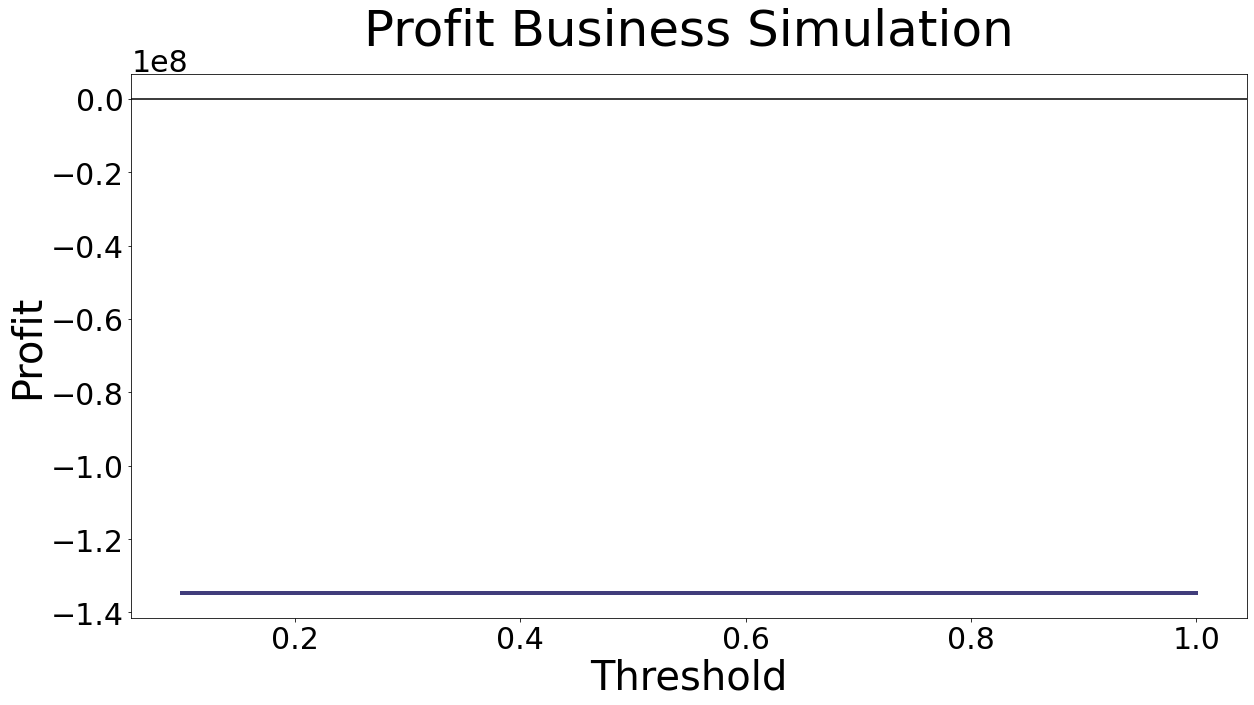

In [22]:
plot_simulation_profits(profits_df_dummy)

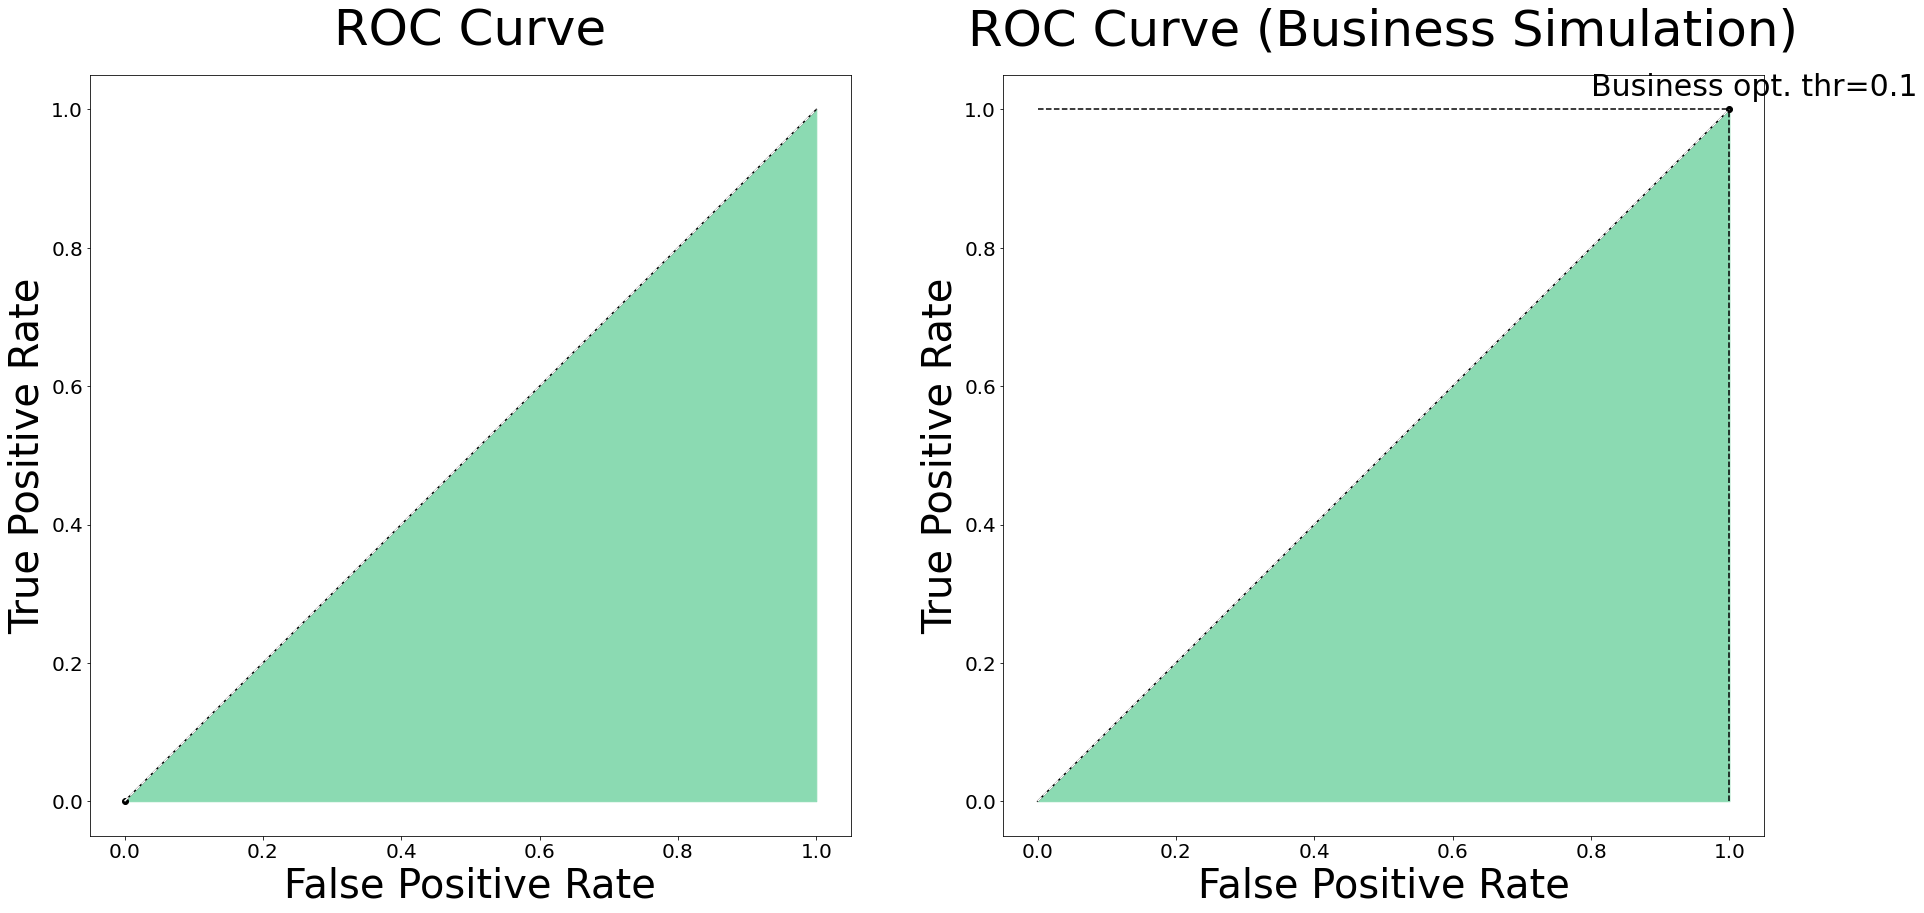

In [23]:
optimal_threshold_dummy = \
    plot_roc_curves(y_train, y_train_pred_proba_dummy[:,1], optimal_business_threshold_dummy)

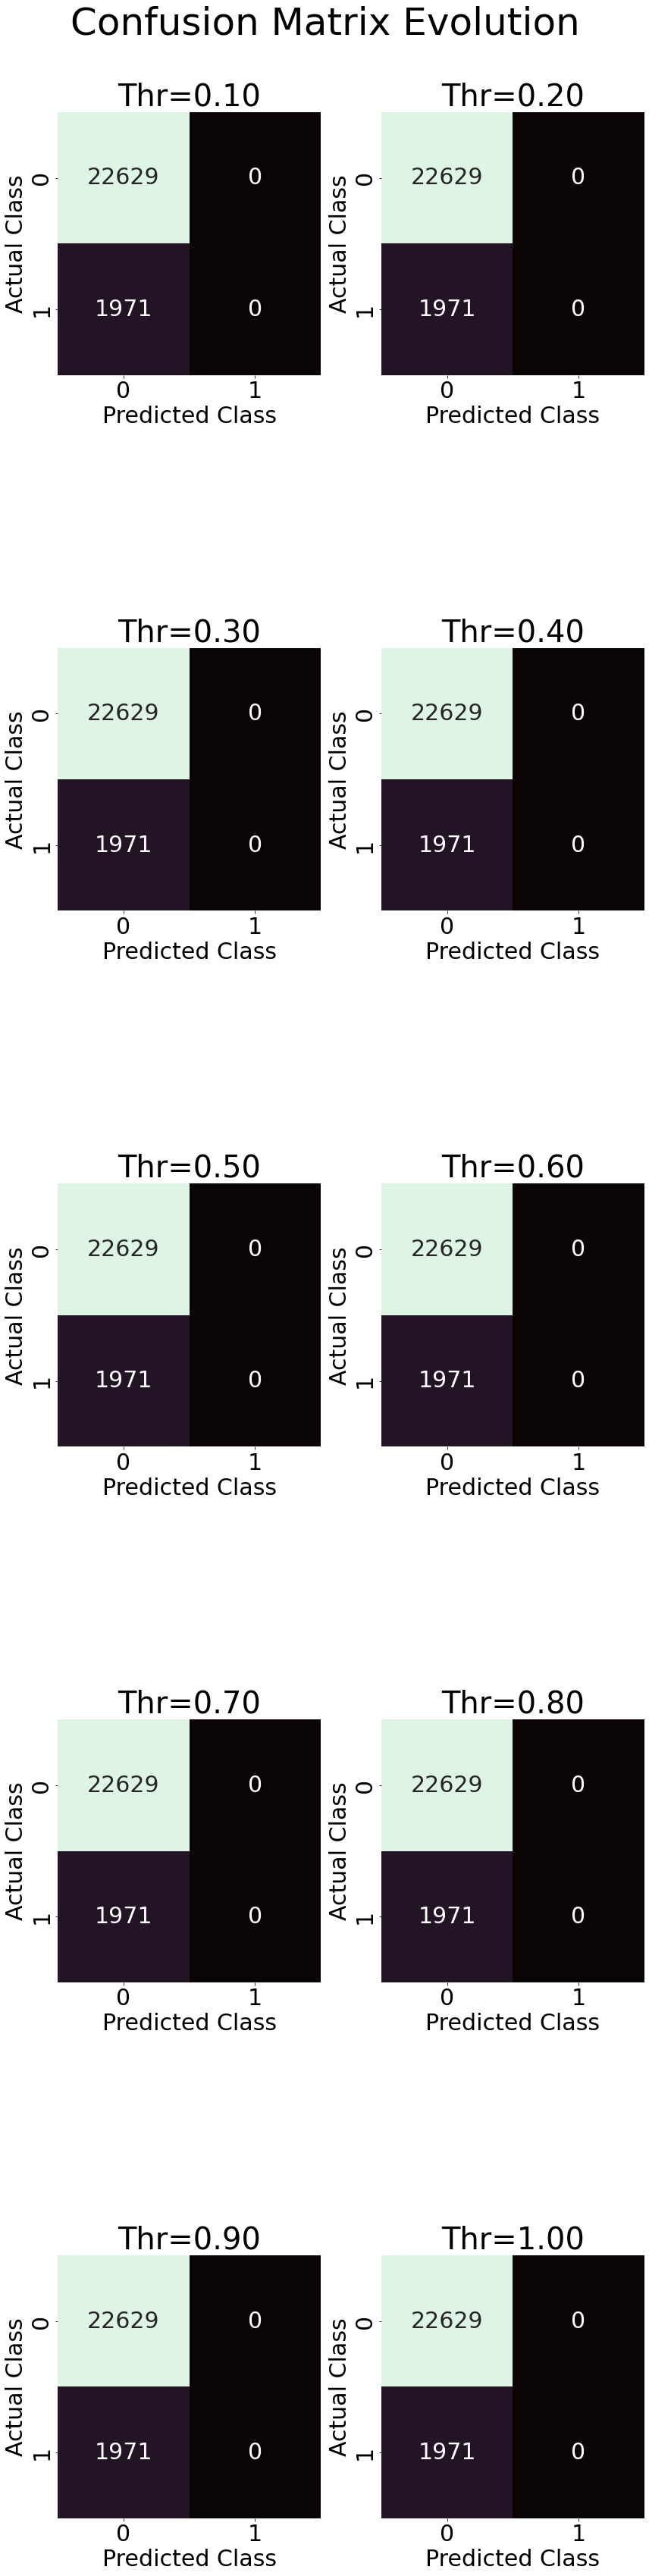

In [24]:
plot_confusion_matrix_evolution(y_train, y_train_pred_proba_dummy[:,1])

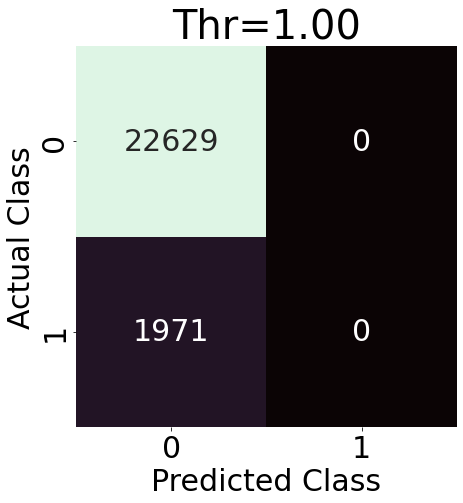

In [25]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_dummy[:,1], 
                              optimal_threshold_dummy)

<h3>Logistic Regression

In [26]:
logistic_regression_pipeline = Pipeline([
    ('Column_transformer', column_transformer),
    ('Sampling', None),
    ('Select_Feature', None),
    ('Scaler', None),
    ('Logistic_regression', LogisticRegression(max_iter=1000,random_state=random_seed))
])

In [27]:
# Params for the grid search

logistic_regression_pipeline_params = [
    
    {
        'Sampling' : sampling_list,
        'Select_Feature' : feature_selectors_list,
        'Scaler' : scaler_list,
        'Logistic_regression__class_weight' : [None, *[{0 : 1.0 - x, 1: x} for x in weights]]
    },
]

len(list(ParameterGrid(logistic_regression_pipeline_params)))

3

In [28]:
# Grid searches logistic_regression_pipeline

logistic_regression_pipeline_gs = GridSearchCV(
                           logistic_regression_pipeline, 
                           logistic_regression_pipeline_params, 
                           cv=5, 
                           scoring=scoring,
                           return_train_score=False,
                           refit='roc_auc',
                           n_jobs = -1,
                           verbose=5)

logistic_regression_pipeline_gs.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [29]:
# O

logistic_regression_scores_df = return_scores_df(logistic_regression_pipeline_gs.cv_results_)

logistic_regression_scores_df['params'] = \
    pd.Series(list(ParameterGrid(logistic_regression_pipeline_params)))

logistic_regression_scores_df\
    .style.highlight_max(subset=['roc_auc','fit_time'], 
                         color=sns.color_palette('mako_r').as_hex()[0])

,roc_auc,fit_time,params
0,0.743519,33.249945,"{'Logistic_regression__class_weight': None, 'Sampling': None, 'Scaler': MinMaxScaler(), 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold='median')}"
1,0.741403,26.313191,"{'Logistic_regression__class_weight': {0: 0.725, 1: 0.275}, 'Sampling': None, 'Scaler': MinMaxScaler(), 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold='median')}"
2,0.742470,24.593552,"{'Logistic_regression__class_weight': {0: 0.5, 1: 0.5}, 'Sampling': None, 'Scaler': MinMaxScaler(), 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold='median')}"


In [30]:
y_train_pred_proba_logistic_regression = \
    cross_val_predict(logistic_regression_pipeline_gs.best_estimator_, 
                      X_train, 
                      y_train, 
                      cv=5, 
                      n_jobs = -1, 
                      method="predict_proba")

In [31]:
profits_df_logistic_regression, optimal_business_threshold_logistic_regression = \
    business_simulation(y_train, X_train['AMT_CREDIT'], 
                        y_train_pred_proba_logistic_regression[:,1], 
                        range_threshold =[0.01,1], range_size=45)

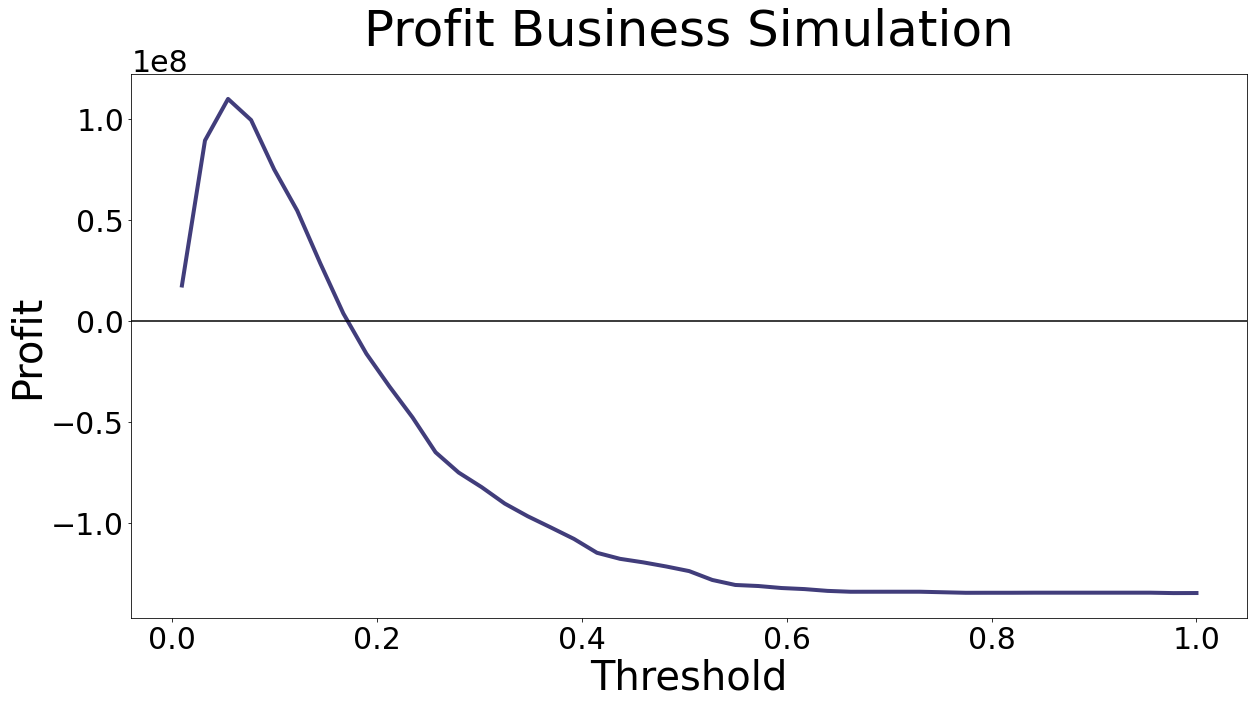

In [32]:
plot_simulation_profits(profits_df_logistic_regression)

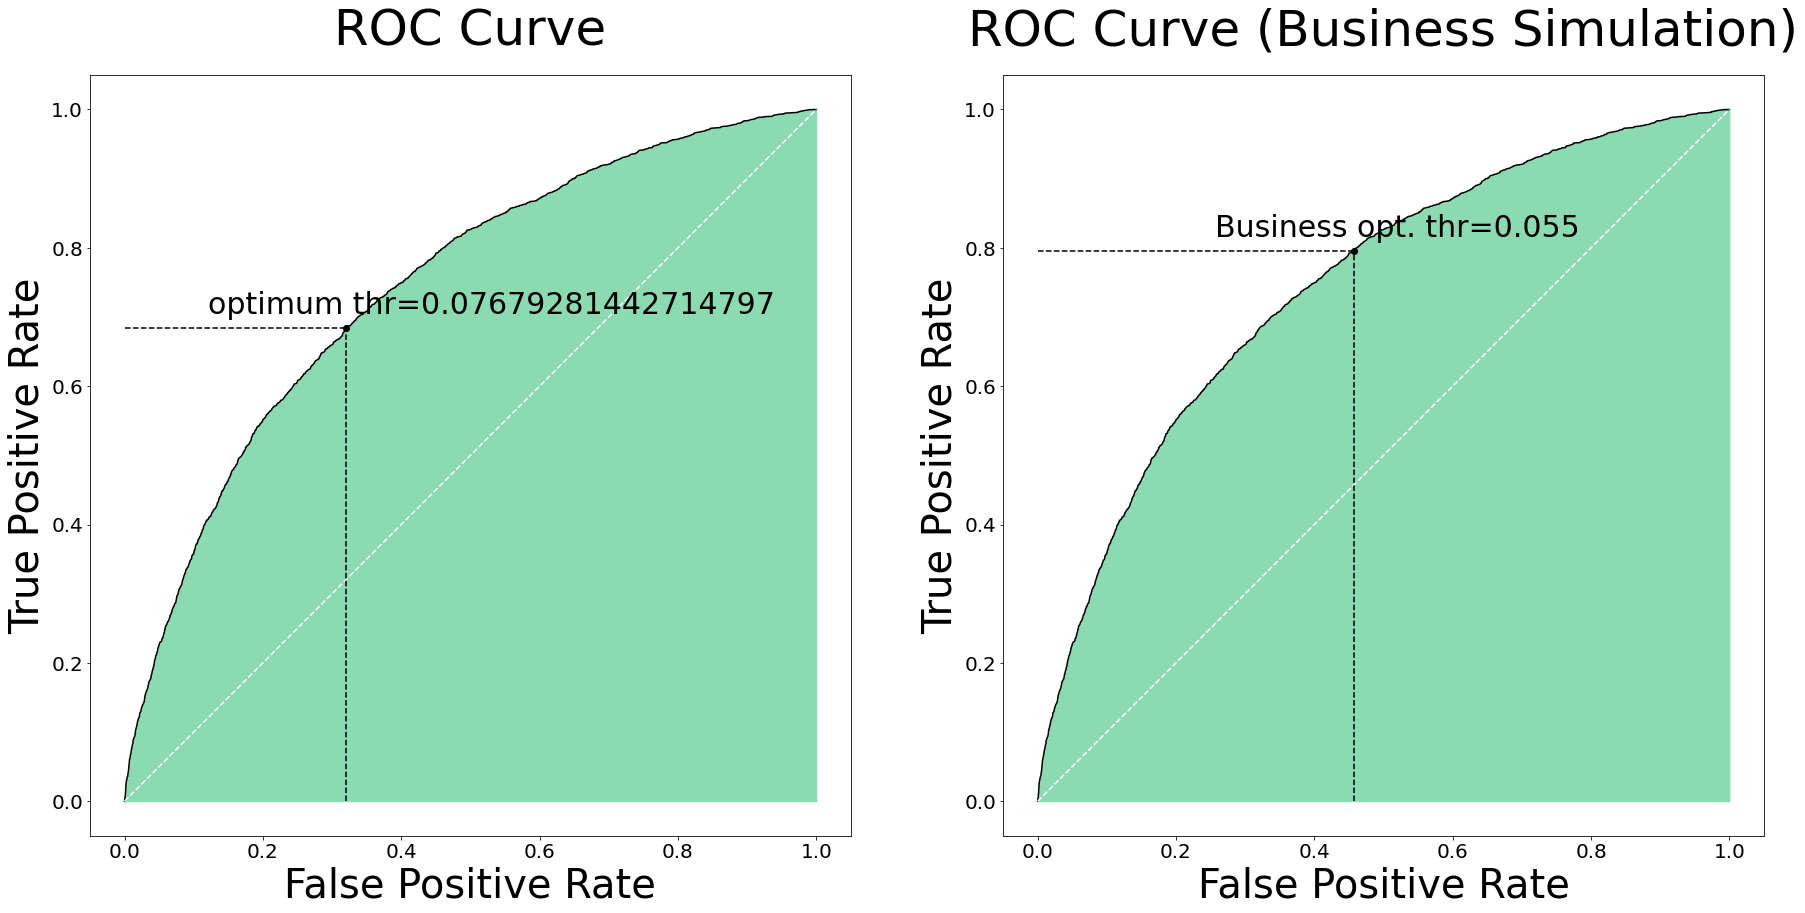

In [33]:
optimal_threshold_logistic_regression = \
    plot_roc_curves(y_train, y_train_pred_proba_logistic_regression[:,1], 
                    optimal_business_threshold_logistic_regression)

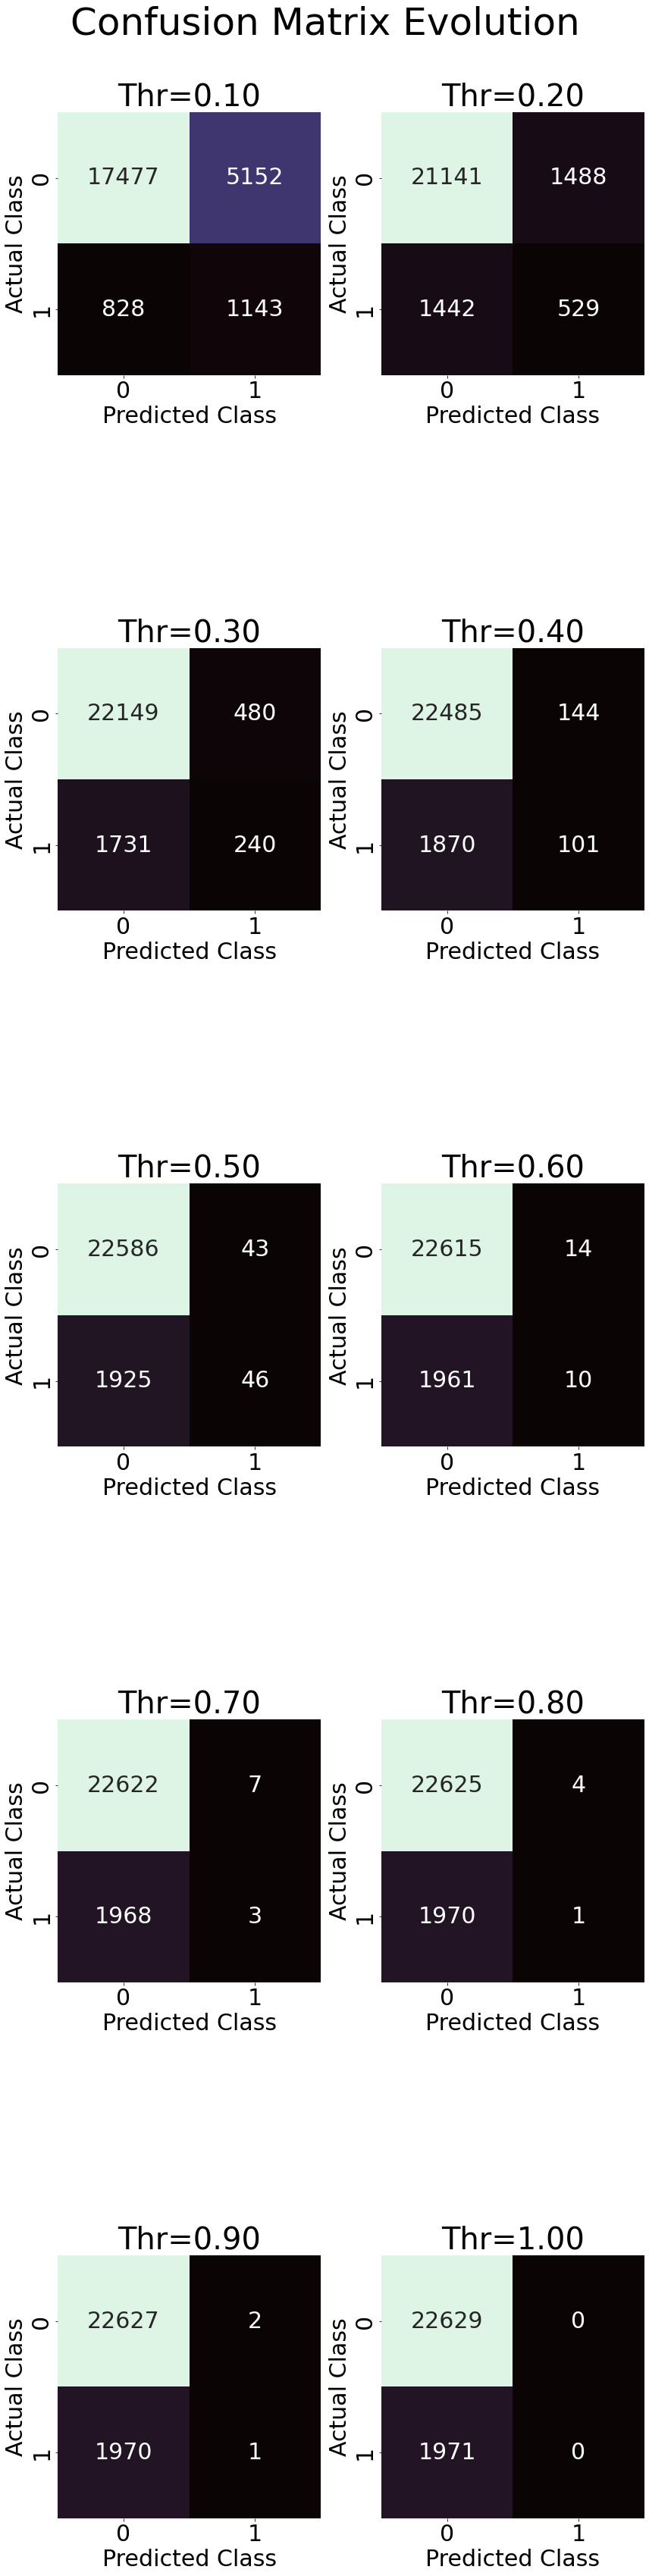

In [34]:
plot_confusion_matrix_evolution(y_train, y_train_pred_proba_logistic_regression[:,1])

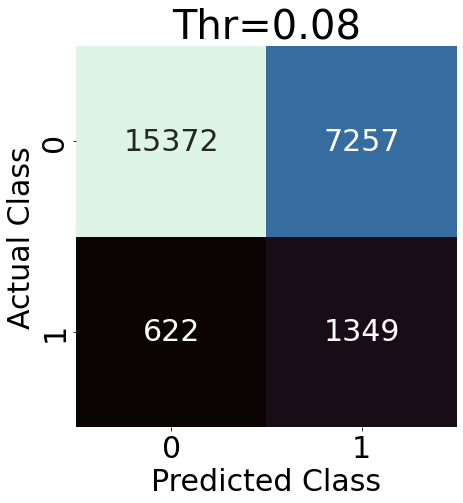

In [35]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_logistic_regression[:,1], 
                              optimal_threshold_logistic_regression)

<h3>Random Forest

In [36]:
random_forest_pipeline = Pipeline([
    ('Column_transformer', column_transformer),
    ('Sampling', None),
    ('Select_Feature', None),
    ('Random_forest', RandomForestClassifier(random_state=random_seed))
])

In [37]:
random_forest_pipeline_params = [
    
    {
        
        'Sampling' : sampling_list,
        
        'Select_Feature' : [SelectFromModel(estimator=LGBMClassifier(random_state=34), 
                                            threshold=1)],#feature_selectors_list,
        
        'Random_forest__max_depth' : [8], #[None, *[x for x in range(2,10,3)]],
        
        'Random_forest__class_weight' : [None, *[{0 : 1.0 - x, 1: x} for x in weights]]
    },
]

len(list(ParameterGrid(random_forest_pipeline_params)))

3

In [38]:
# Grid searches random_forest_pipeline

random_forest_pipeline_gs = GridSearchCV(
                                   random_forest_pipeline, 
                                   random_forest_pipeline_params, 
                                   cv=5, 
                                   scoring=scoring,
                                   return_train_score=False,
                                   refit='roc_auc',
                                   verbose=5,
                                   n_jobs = -1)

random_forest_pipeline_gs.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [39]:
random_forest_scores_df = return_scores_df(random_forest_pipeline_gs.cv_results_)

random_forest_scores_df['params'] = \
    pd.Series(list(ParameterGrid(random_forest_pipeline_params)))

random_forest_scores_df\
    .style.highlight_max(subset=['roc_auc','fit_time'], 
                         color=sns.color_palette('mako_r').as_hex()[0])

,roc_auc,fit_time,params
0,0.714102,27.043479,"{'Random_forest__class_weight': None, 'Random_forest__max_depth': 8, 'Sampling': None, 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold=1)}"
1,0.698910,26.192302,"{'Random_forest__class_weight': {0: 0.725, 1: 0.275}, 'Random_forest__max_depth': 8, 'Sampling': None, 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold=1)}"
2,0.714102,24.483993,"{'Random_forest__class_weight': {0: 0.5, 1: 0.5}, 'Random_forest__max_depth': 8, 'Sampling': None, 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold=1)}"


In [40]:
y_train_pred_proba_random_forest= \
    cross_val_predict(random_forest_pipeline_gs.best_estimator_, 
                      X_train, 
                      y_train, 
                      cv=5, 
                      n_jobs = -1, 
                      method="predict_proba")

In [41]:
profits_df_random_forest, optimal_business_threshold_random_forest = \
    business_simulation(y_train, X_train['AMT_CREDIT'], 
                        y_train_pred_proba_random_forest[:,1], 
                        range_threshold =[0.01,1], range_size=45)

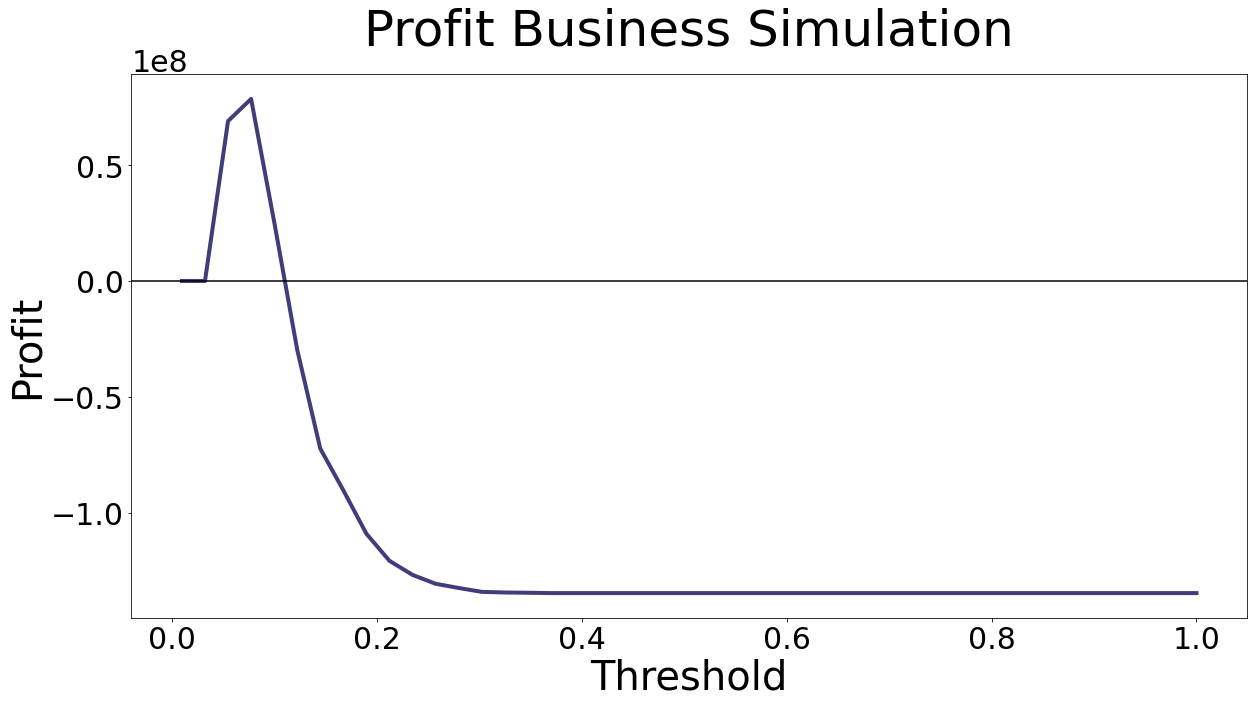

In [42]:
plot_simulation_profits(profits_df_random_forest)

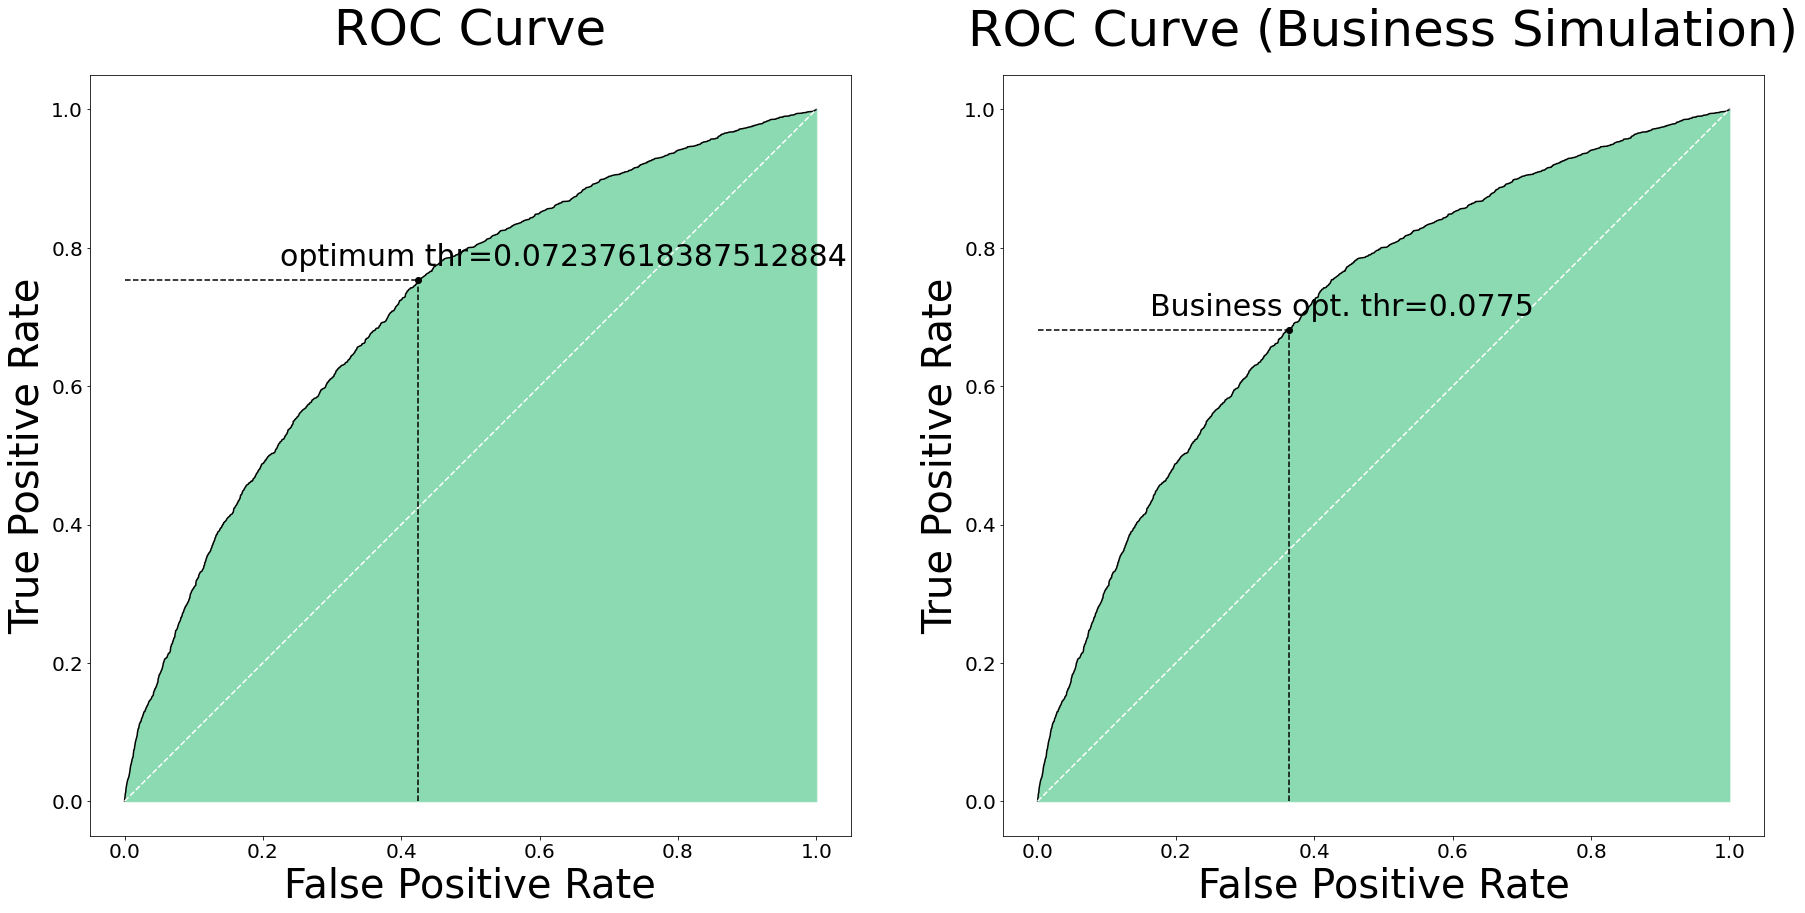

In [43]:
optimal_threshold_random_forest = \
    plot_roc_curves(y_train, y_train_pred_proba_random_forest[:,1], 
                    optimal_business_threshold_random_forest)

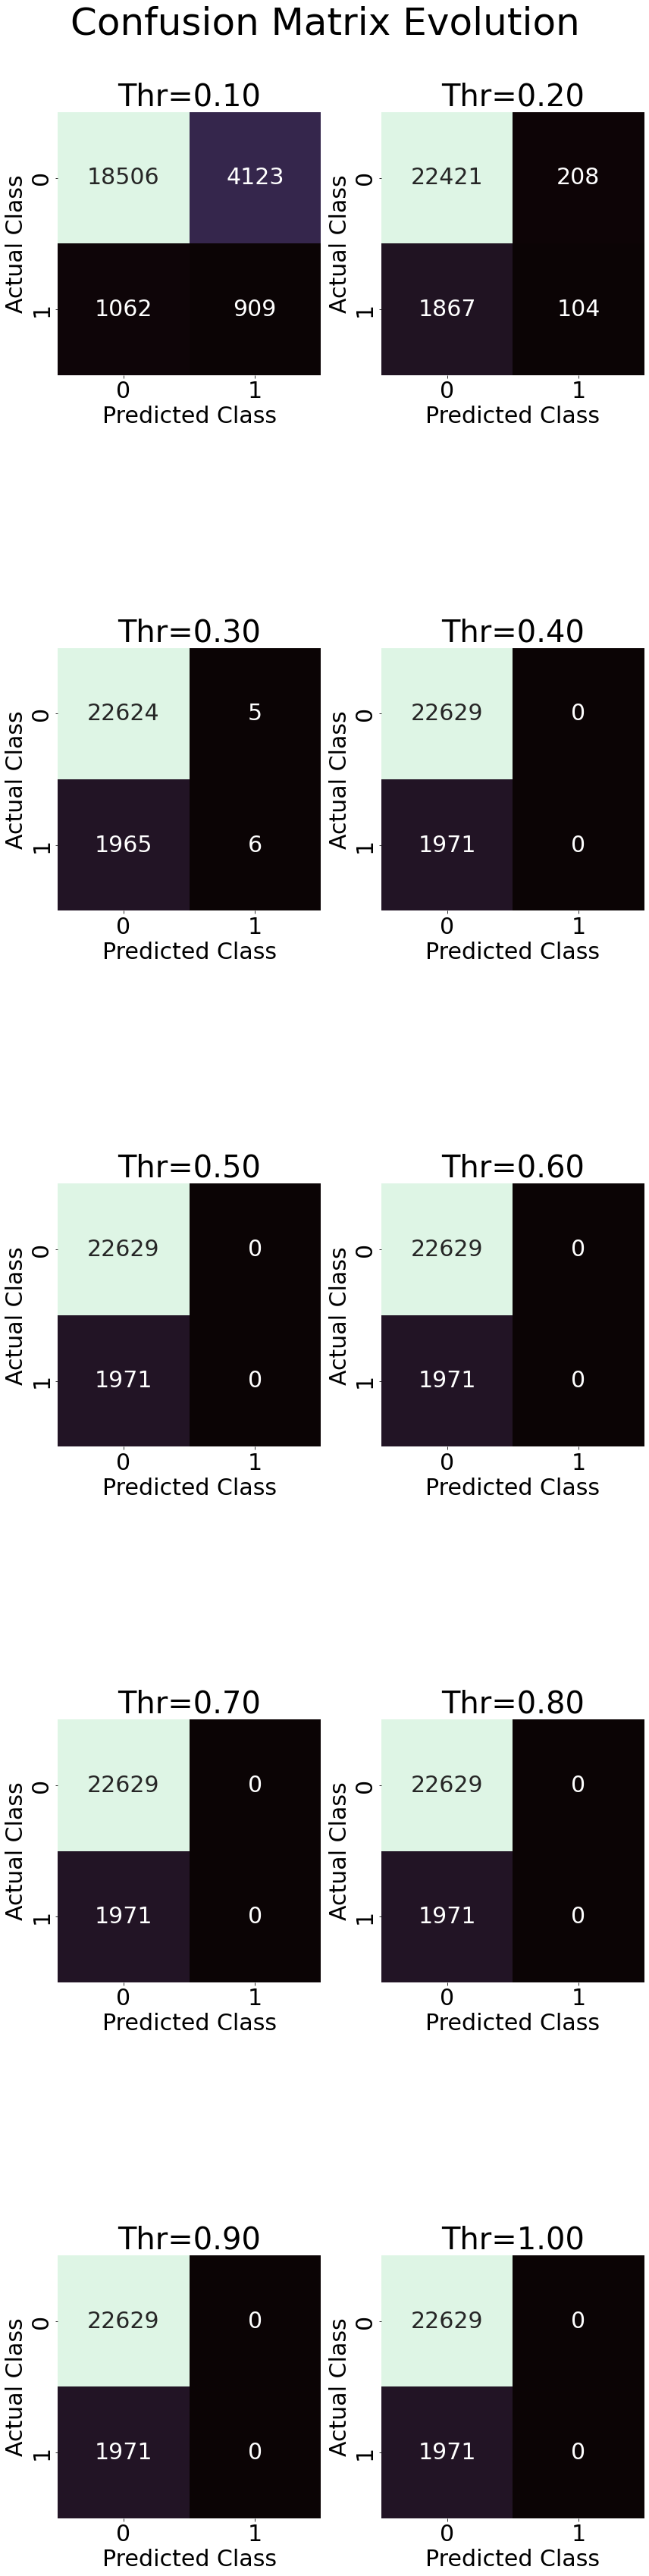

In [44]:
plot_confusion_matrix_evolution(y_train, y_train_pred_proba_random_forest[:,1])

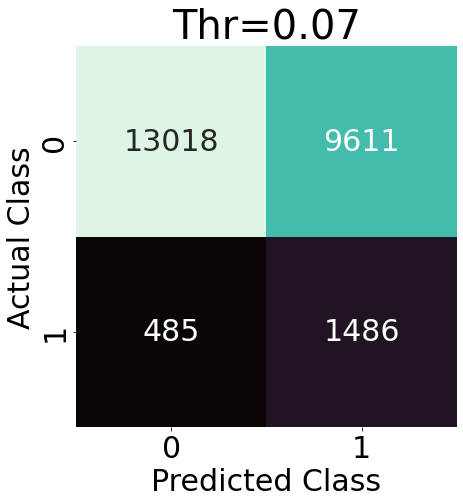

In [45]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_random_forest[:,1], 
                              optimal_threshold_random_forest)

<h3>XGBOOST Classifier

In [46]:
xgboost_pipeline = Pipeline([
    ('Column_transformer', column_transformer),
    ('Sampling', None),
    ('Select_Feature', None),
    ('Xgboost', XGBClassifier(use_label_encoder=False, random_state=random_seed))
])

In [47]:
xgboost_params = [
    
    {
        
        'Sampling' : sampling_list,
        
        'Select_Feature' : [None], #feature_selectors_list,

        'Xgboost__max_depth' : [x for x in range(2,10,3)],
    },
]

len(list(ParameterGrid(xgboost_params)))

3

In [48]:
%%capture --no-stderr

# Grid searches xgboost_pipeline

xgboost_gs = GridSearchCV(xgboost_pipeline, 
                          xgboost_params, 
                          cv=5, 
                          scoring=scoring,
                          return_train_score=False,
                          refit='roc_auc',
                          verbose=5,
                          n_jobs = -1)

xgboost_gs.fit(X_train, y_train);

In [49]:
xgboost_scores_df = return_scores_df(xgboost_gs.cv_results_)

xgboost_scores_df['params'] = \
    pd.Series(list(ParameterGrid(xgboost_params)))

xgboost_scores_df\
    .style.highlight_max(subset=['roc_auc','fit_time'], 
                         color=sns.color_palette('mako_r').as_hex()[0])

,roc_auc,fit_time,params
0,0.742236,48.198845,"{'Sampling': None, 'Select_Feature': None, 'Xgboost__max_depth': 2}"
1,0.714698,109.055505,"{'Sampling': None, 'Select_Feature': None, 'Xgboost__max_depth': 5}"
2,0.703605,144.999311,"{'Sampling': None, 'Select_Feature': None, 'Xgboost__max_depth': 8}"


In [50]:
y_train_pred_proba_xgboost = \
    cross_val_predict(xgboost_gs.best_estimator_, 
                      X_train, 
                      y_train, 
                      cv=5, 
                      n_jobs = -1, 
                      method="predict_proba")

In [51]:
profits_df_xgboost, optimal_business_threshold_xgboost = \
    business_simulation(y_train, X_train['AMT_CREDIT'], 
                        y_train_pred_proba_xgboost[:,1], 
                        range_threshold =[0.01,1], range_size=45)

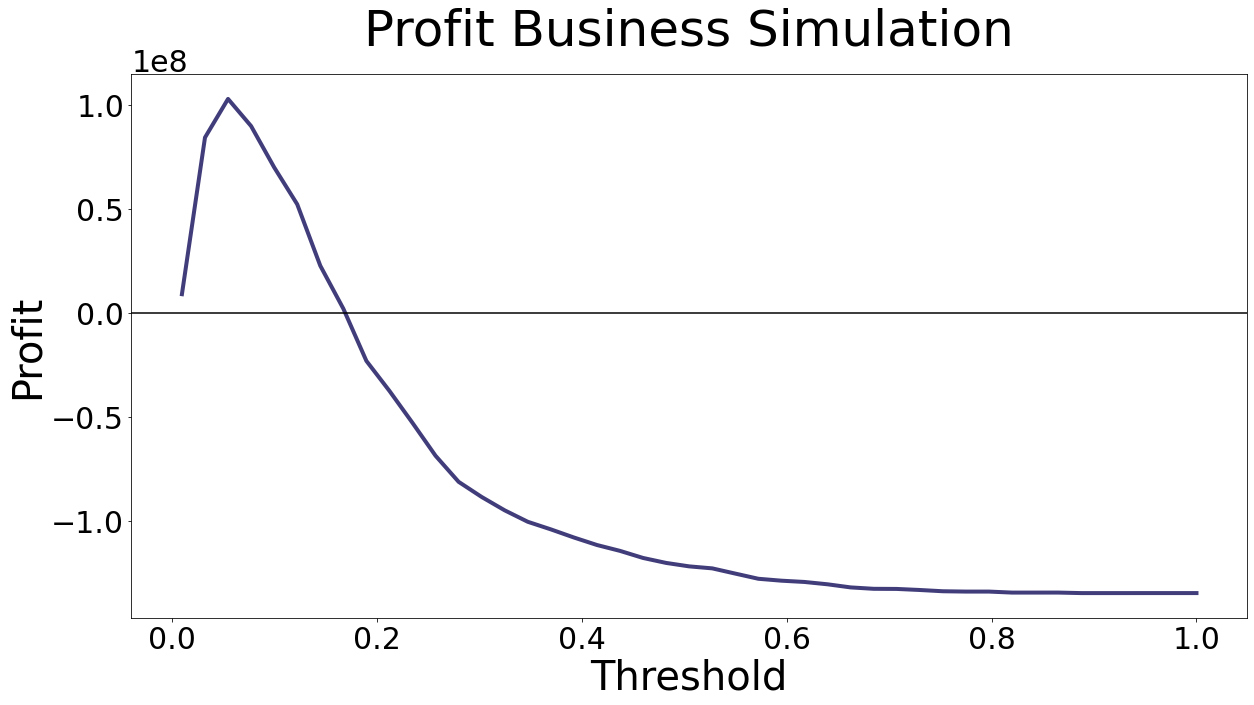

In [52]:
plot_simulation_profits(profits_df_xgboost)

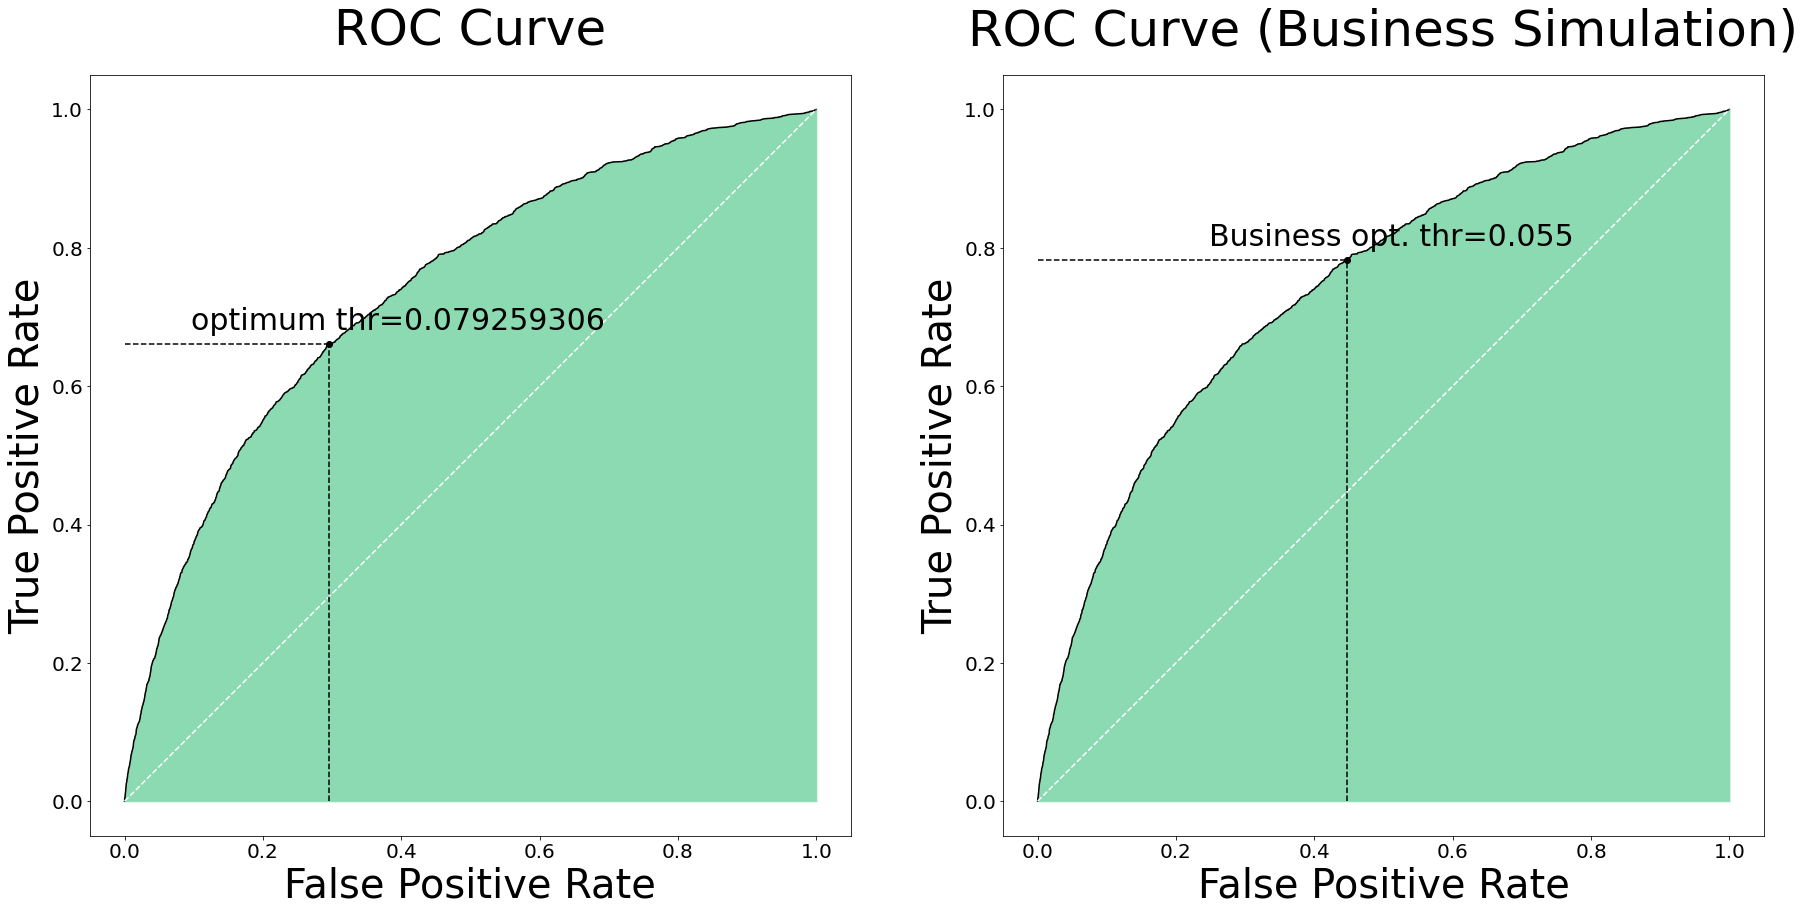

In [53]:
optimal_threshold_xgboost = \
    plot_roc_curves(y_train, y_train_pred_proba_xgboost[:,1], 
                    optimal_business_threshold_xgboost)

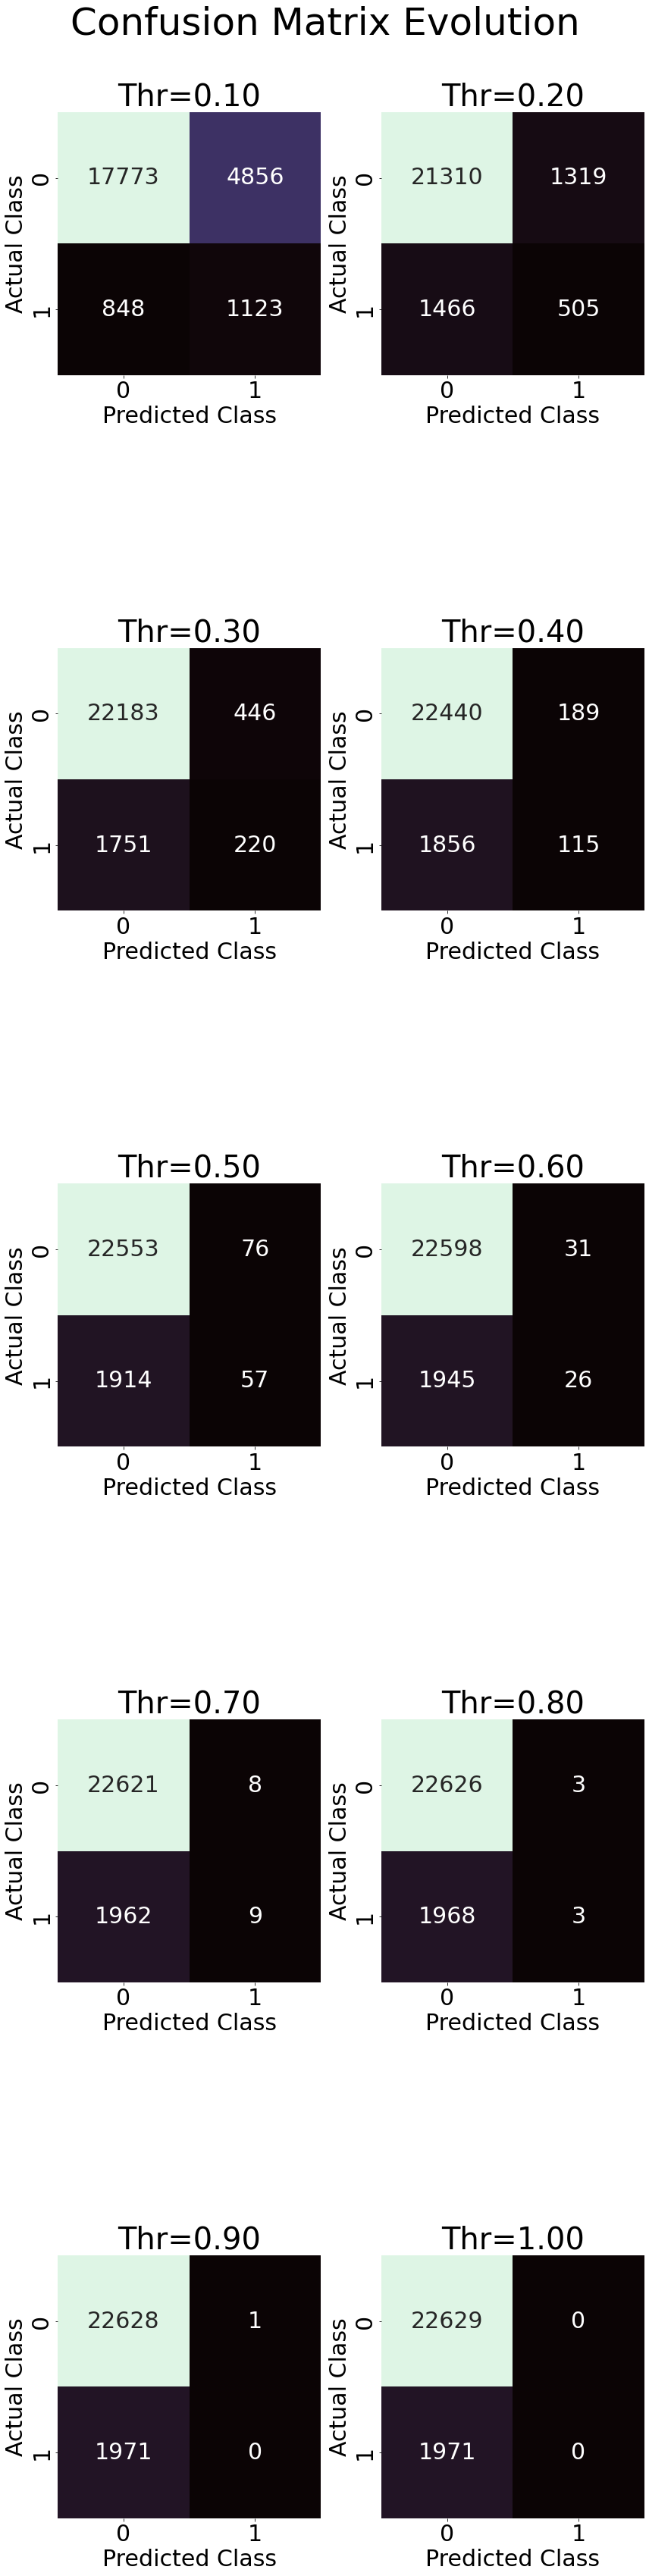

In [54]:
plot_confusion_matrix_evolution(y_train, y_train_pred_proba_xgboost[:,1])

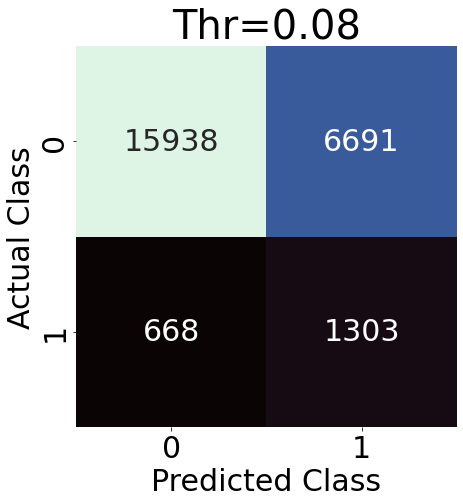

In [55]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_xgboost[:,1], 
                              optimal_threshold_xgboost)

<h3>Light GBM

In [56]:
light_gbm_pipeline = Pipeline([
    ('Column_transformer', column_transformer),
    ('Sampling', None),
    ('Select_Feature', None),
    ('Light_gbm', LGBMClassifier(random_state=random_seed))
])

In [57]:
light_gbm_params = [
    
    {
        
        'Sampling' : sampling_list,

        'Light_gbm__max_depth' : [2], #[x for x in range(2,10,3)],
        
        'Select_Feature' : feature_selectors_list,
        
        'Light_gbm__class_weight' : [{0 : 1.0 - x, 1: x} for x in weights]
    },
]

len(list(ParameterGrid(light_gbm_params)))

2

In [58]:
# Grid searches light_gbm_pipeline
    
light_gbm_gs = GridSearchCV(light_gbm_pipeline, 
                            light_gbm_params, 
                            cv=5, 
                            scoring=scoring,
                            return_train_score=False,
                            refit='roc_auc',
                            verbose=5,
                            n_jobs = -1)

light_gbm_gs.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [59]:
light_gbm_scores_df = return_scores_df(light_gbm_gs.cv_results_)

light_gbm_scores_df['params'] = \
    pd.Series(list(ParameterGrid(light_gbm_params)))

light_gbm_scores_df\
    .style.highlight_max(subset=['roc_auc','fit_time'], 
                         color=sns.color_palette('mako_r').as_hex()[0])

,roc_auc,fit_time,params
0,0.746482,27.549111,"{'Light_gbm__class_weight': {0: 0.725, 1: 0.275}, 'Light_gbm__max_depth': 2, 'Sampling': None, 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold='median')}"
1,0.745873,21.664279,"{'Light_gbm__class_weight': {0: 0.5, 1: 0.5}, 'Light_gbm__max_depth': 2, 'Sampling': None, 'Select_Feature': SelectFromModel(estimator=LGBMClassifier(random_state=34), threshold='median')}"


In [60]:
y_train_pred_proba_light_gbm = \
    cross_val_predict(light_gbm_gs.best_estimator_, 
                      X_train, 
                      y_train, 
                      cv=5, 
                      n_jobs = -1, 
                      method="predict_proba")

In [61]:
profits_df_light_gbm, optimal_business_threshold_light_gbm = \
    business_simulation(y_train, X_train['AMT_CREDIT'], 
                        y_train_pred_proba_light_gbm[:,1], 
                        range_threshold =[0.01,1], 
                        range_size=45)

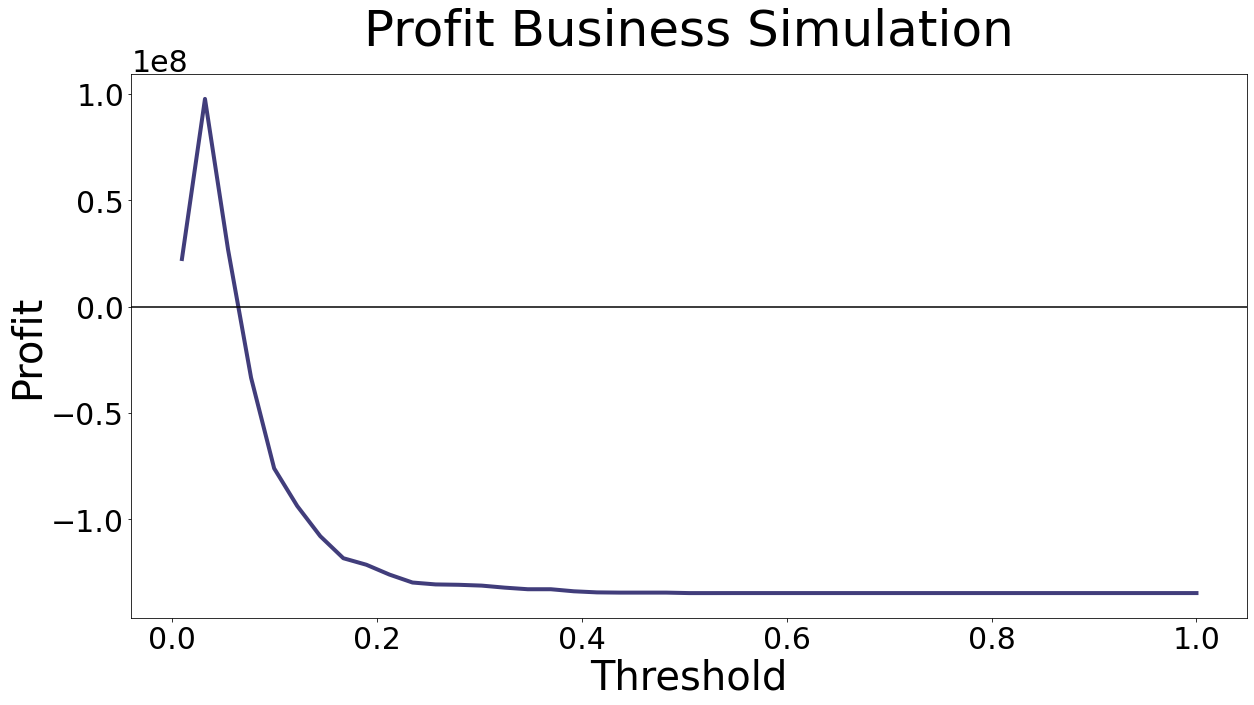

In [62]:
plot_simulation_profits(profits_df_light_gbm)

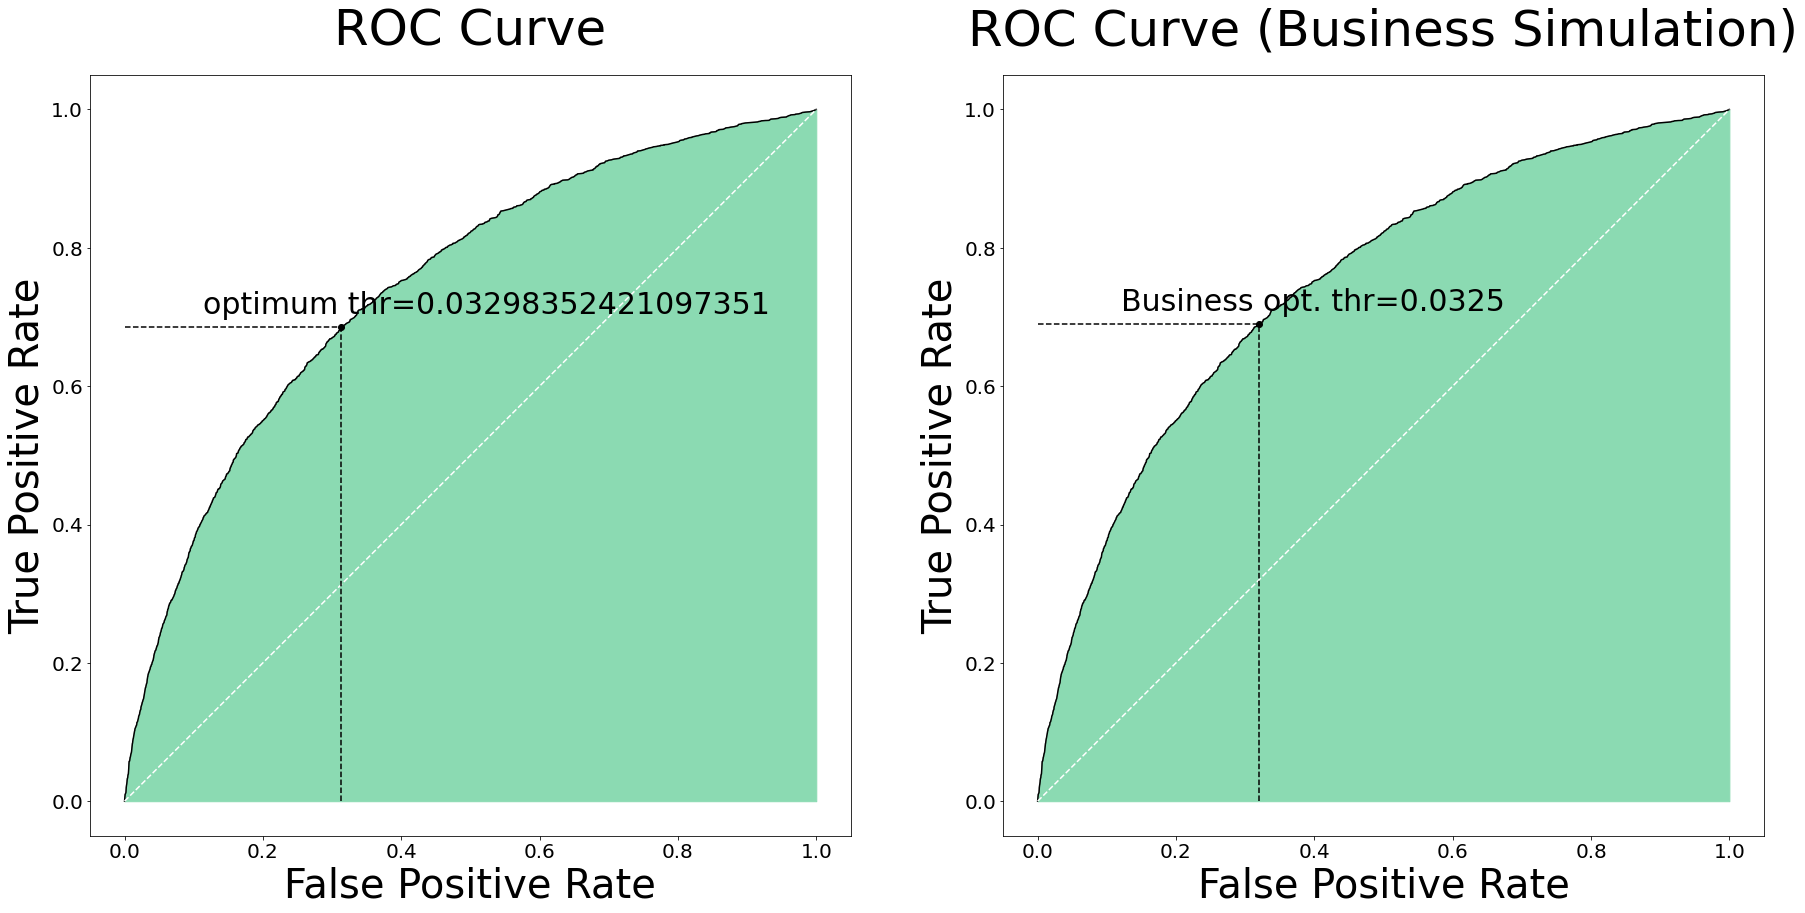

In [63]:
optimal_threshold_light_gbm = \
    plot_roc_curves(y_train, y_train_pred_proba_light_gbm[:,1], 
                    optimal_business_threshold_light_gbm)

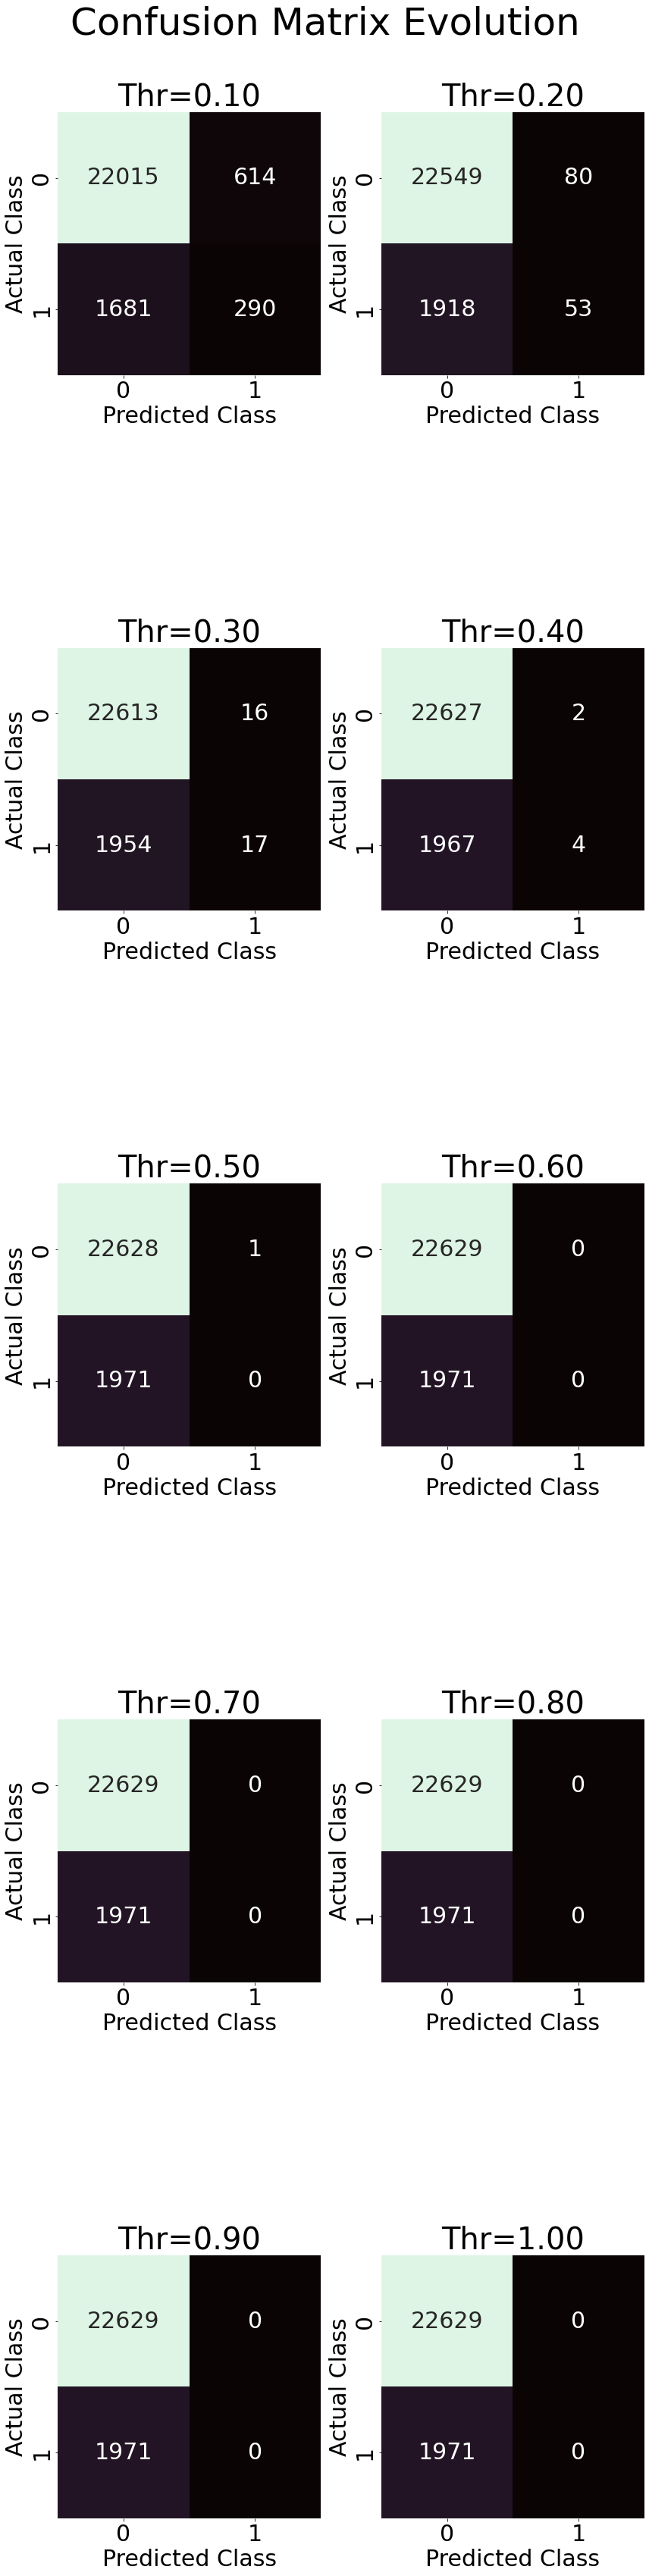

In [64]:
plot_confusion_matrix_evolution(y_train, y_train_pred_proba_light_gbm[:,1])

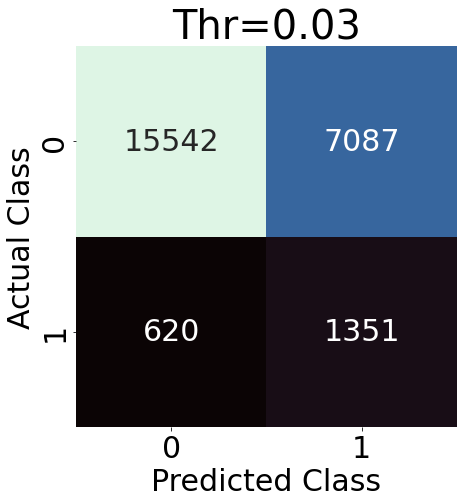

In [65]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_light_gbm[:,1], 
                              optimal_threshold_light_gbm)

<h1>Model Selection

In [66]:
grouped_scores = \
    pd.concat([light_gbm_scores_df.sort_values(by='roc_auc', ascending=False).iloc[[0]],
               xgboost_scores_df.sort_values(by='roc_auc', ascending=False).iloc[[0]],
               random_forest_scores_df.sort_values(by='roc_auc', ascending=False).iloc[[0]],
               logistic_regression_scores_df.sort_values(by='roc_auc', ascending=False).iloc[[0]],
               dummy_scores_df.sort_values(by='roc_auc', ascending=False).iloc[[0]]], axis=0)

grouped_scores.index = ['LightGBM', 'XGBOOST', 'Random Forest', 'Logistic Regression', 'Dummy']

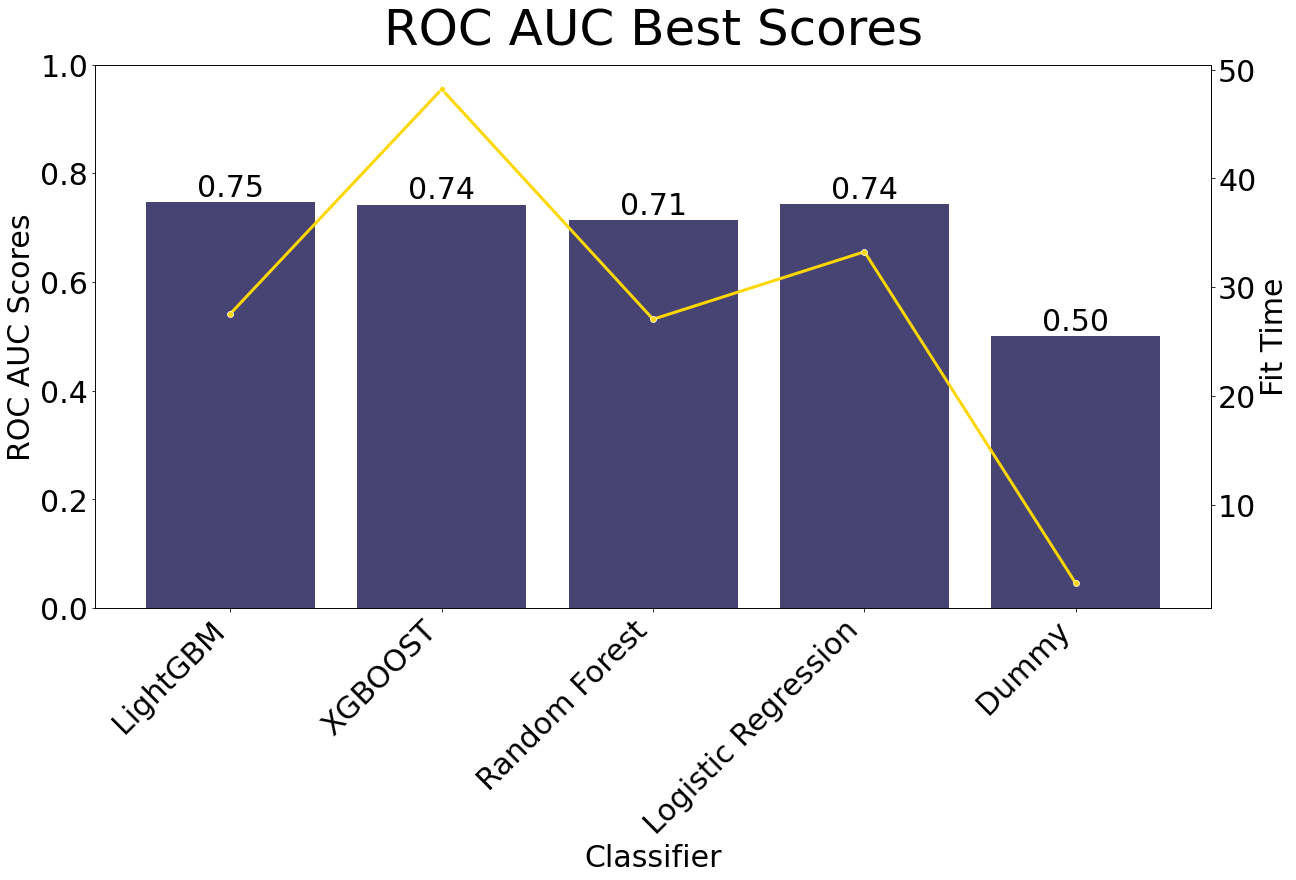

In [67]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=grouped_scores, 
            x=grouped_scores.index,
            y='roc_auc',
            palette = [sns.color_palette('mako')[1]],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('ROC AUC Scores', fontsize=text_size)
ax.set_xlabel('Classifier', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.xticks(rotation=45, ha='right')

plt.title('ROC AUC Best Scores',
          fontsize=title_size,
          pad=20) 

ax2 = plt.twinx()

sns.lineplot(x=grouped_scores.index, y='fit_time', 
             data=grouped_scores, marker='o', color='gold', lw=3, ax=ax2)

ax2.tick_params(labelsize=tick_size)
ax2.set_ylabel('Fit Time', fontsize=text_size)

plt.show();

<h6>Train Data

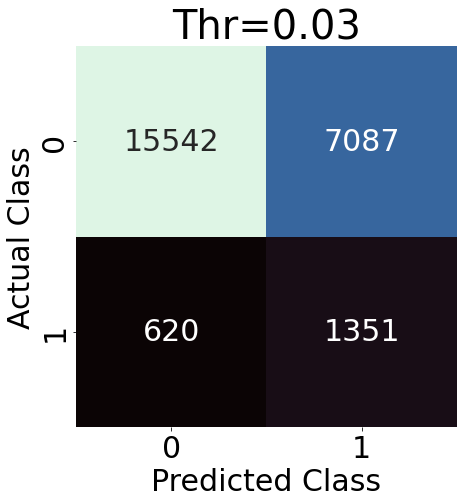

In [68]:
plot_optimal_confusion_matrix(y_train, 
                              y_train_pred_proba_light_gbm[:,1], 
                              optimal_threshold_light_gbm)

<H6>Test data

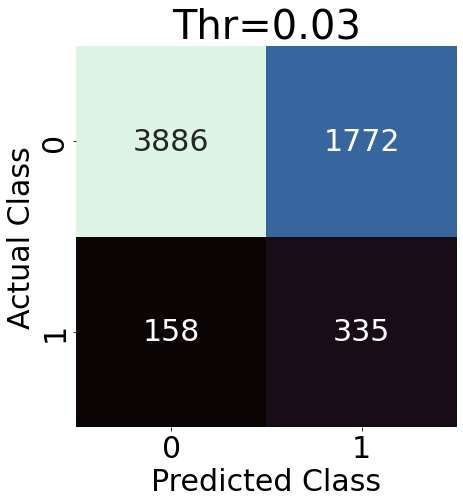

In [69]:
plot_optimal_confusion_matrix(y_test, 
                              light_gbm_gs.best_estimator_.predict_proba(X_test)[:,1], 
                              optimal_threshold_light_gbm)

In [70]:
# Job lib Export

# joblib.dump(light_gbm_gs.best_estimator_, 
#             r'E:\Data\Projet 7\Model\lightgbm.pkl')

<h1>Model Interpretability

In [71]:
X_transformed = light_gbm_gs.best_estimator_[:-1].transform(X_train)

columns_names_out = light_gbm_gs.best_estimator_[:-1].get_feature_names_out()

columns_names_out_cleaned = \
            [re.sub('(Categorical_pipeline__)|(Numerical_pipeline__)', '', i) 
            for i in columns_names_out]

In [72]:
tree_explainer = shap.TreeExplainer(light_gbm_gs.best_estimator_[-1])

In [73]:
light_gbm_shap_value = tree_explainer.shap_values(X_transformed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


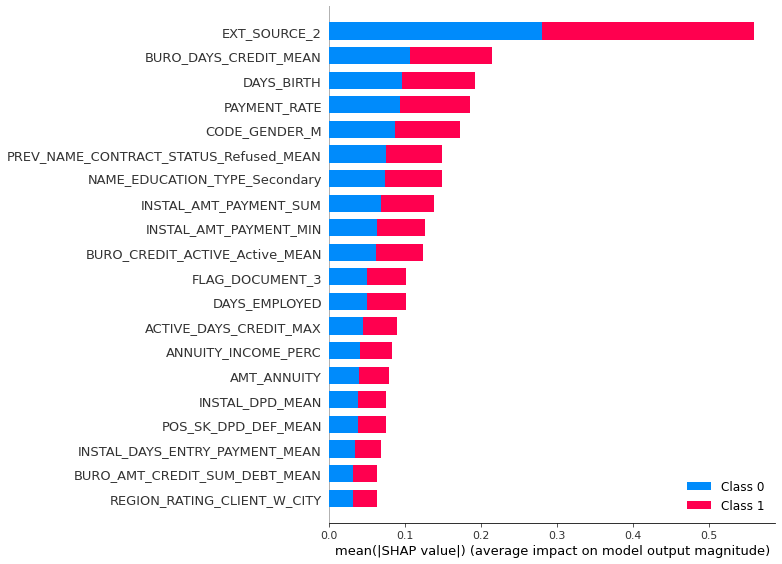

In [74]:
shap.summary_plot(light_gbm_shap_value, feature_names=columns_names_out_cleaned)

In [77]:
light_gbm_gs.best_estimator_.predict_proba(X_train.iloc[[2]])
(light_gbm_gs.best_estimator_.predict_proba(X_train.iloc[[2]])[:,1] >= 0.03).astype(int)

array([[0.98845227, 0.01154773]])

array([0])

In [78]:
shap.force_plot(tree_explainer.expected_value[0], 
                light_gbm_shap_value[0][2], 
                feature_names=columns_names_out_cleaned, 
                link='logit')

In [84]:
light_gbm_gs.best_estimator_.predict_proba(X_train.iloc[[20]])
(light_gbm_gs.best_estimator_.predict_proba(X_train.iloc[[20]])[:,1] >= 0.03).astype(int)

array([[0.9177781, 0.0822219]])

array([1])

In [85]:
shap.force_plot(tree_explainer.expected_value[0], 
                light_gbm_shap_value[0][20], 
                feature_names=columns_names_out_cleaned, 
                link='logit')